<html>
    <summary></summary>
         <div> <p></p> </div>
         <div style="font-size: 20px; width: 800px;">
              <h1>
               <left>Group practice on fitting models to data.</left>
              </h1>
              <p><left>============================================================================</left> </p>
<pre>Course: ASU CBP Summer School 2025
Instructor: Dr. Douglas Shepherd
Contact Info: douglas.shepherd@asu.edu
Authors: Dr. Douglas Shepherd
</pre>
         </div>
    </p>

</html>

<details>
  <summary>Copyright info</summary>

```
Copyright 2025 Douglas Shepherd

Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer.

2. Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution.

3. Neither the name of the copyright holder nor the names of its contributors may be used to endorse or promote products derived from this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
```
<details>



<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/QI2lab/2025-CBP-SummerSchool/blob/main/Module3-ModelingBiochemicalReactions/M3D_Fitting_Models_to_Data.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/QI2lab/2025-CBP-SummerSchool/blob/main/Module3-ModelingBiochemicalReactions/M3D_Fitting_Models_to_Data.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

----------
# Learning Objectives for this group exercise:
--------------

After this group exercise, you should be able to:
* Define how to use least-squares error to provide a goodness-of-fit metric for a model to data
* Define how to use a parametric distibution test to provide a goodness-of-fit metric for a model to data
* Perform parameter fitting for an ODE, SSA, and CME model of birth-decay

![alt text](https://github.com/QI2lab/2025-CBP-SummerSchool/blob/main/Module3-ModelingBiochemicalReactions/Figures/StoichiometryAndPropensity_2023/Slide27.png?raw=1)

In [1]:
# Load necessary packages and libraries
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc
rc('animation', html='jshtml')
figSize=600
rng = np.random.default_rng()

# 1. Simulate birth-decay using random parameters

### Create the birth-decay model system
This system will have three randomly drawn parameters:
1. $N_{initial}^{experiment}$, the number of starting molecules.
2. $k_{1}^{experiment}$, the birth rate.
2. $k_{2}^{experiment}$, the decay rate.

### Define the functions needed to run an SSA at set time points

In [6]:
def initial_condition():
  # Here we have a single species (N=1) with units x0 = (mg/mL)
  x0=np.array([rng.uniform(low=5,high=10)])

  return x0

def stoichometry():
  # Define the stoichiometry matrix as a 1 (species) by 2 (reaction) numpy array,
  S=np.array([[1,-1]])

  return S

def propensities():
  # Define the reaction rate parameters as a dictionary
  k1_experiment = rng.uniform(low=0.15, high=0.35)
  k2_experiment = rng.uniform(low=0.01, high=0.1)
  pars = {'k1': k1_experiment, 'k2': k2_experiment}
  # Units are:  k1 = (mg/mL) / minute
  #             k2 = 1 / minute

  return pars

  # Define the reaction rate (propensity) functions
def W(x,t,pars):
  return np.array([pars['k1'],pars['k2']*x[0]])

In [2]:
# Run the many SSAs using the random parameters
# Let's define a simple function that computes the time of the next reaction given our propensity functions:
def next_time(x, t, pars):
    return -np.log(np.random.rand()) / np.sum(W(x, t, pars))

# Let's define a simple function that computes the index of the next reaction given our propensity functions:
def next_reaction(x, t, pars):
    Wx = W(x, t, pars)
    Wx_sum = np.sum(Wx)
    r = np.random.rand()
    i = 0
    W_sum = Wx[0]
    while W_sum / Wx_sum < r:
        i += 1
        W_sum += Wx[i]
    return i

# Gillespie algorithm to return the trajectories at specific time points.
def gillespie1(x0, t0, tmax, S, pars, trajectory_times):

    # Initialize the time and the state
    t = t0
    x = x0

    # Initialize the output
    states = np.zeros((len(trajectory_times), len(x0)))

    # next time index
    nextTimeIndex = 0

    # Run the simulation
    while t < tmax:
        # Compute the time of the next reaction
        tau = next_time(x, t, pars)
        t += tau

        # Check to see if we need to save the state
        while t >= trajectory_times[nextTimeIndex]:
            states[nextTimeIndex] = x
            nextTimeIndex += 1
            if nextTimeIndex >= len(trajectory_times):
                return np.squeeze(states)

        # Compute the index of the next reaction
        i = next_reaction(x, t, pars)

        # Update the state
        x = x + S[:, i]

### Run the simulated experiment
  
We will treat this like a simulated experiment, where you have limited time and resources. For our purposes, that means that the number of experiments * number of time points has to be less than 500 ($n_{traj} \times n_{timepoints} <= 500$)

In [28]:
def run_simulated_experiment(n_traj,t_max,n_timepoints):

  x0 = initial_condition()
  S = stoichometry()
  pars = propensities()

  assert n_traj * n_timepoints <= 500, "n_traj * n_timepoints must be less than 1000"
  trajectory_times = np.linspace(0,t_max,n_timepoints)

  # Initialize the results
  trajectories = np.zeros((n_traj, len(trajectory_times)))
  for i in range(n_traj):
      trajectories[i,:] = gillespie1(x0, 0, t_max, S, pars, trajectory_times)

  return trajectories, trajectory_times, (x0,pars['k1'],pars['k2'])

n_traj = 10
t_max = 100
n_timepoints = 50
experimental_results, trajectory_times, experimental_parameters = run_simulated_experiment(n_traj,t_max,n_timepoints)

### Plot the simulated experiment results

In [ ]:
# Plot the results for the molecule counts
plt.plot(trajectory_times, experimental_results.T, color='gray', alpha=0.1)
plt.xlabel('Time')
plt.ylabel('Discrete number of molecules')
plt.title('Counts versus time')
plt.show()

plt.plot(trajectory_times, np.mean(experimental_results, axis=0), color='r', linewidth=2)
plt.fill_between(trajectory_times, np.mean(experimental_results, axis=0) - np.std(experimental_results, axis=0), np.mean(experimental_results, axis=0) + np.std(experimental_results, axis=0), color='r', alpha=0.3)
plt.xlabel('Time')
plt.ylabel('Mean and std. dev. for number of molecules')
plt.title('Counts versus time')
plt.show()

# 2. Fitting the data

### Strategy

1. Define what kind of model to use (ODE, SSA, or CME)
2. Decide on a fitting routine to use (least squares, likelihood, etc...)
3. Run the fitting and compare the obtained $k_1$, $k_2$ to the known $k_1^{experiment}$, $k_2^{experiment}$
4. Discuss how to improve your parameter estimates

In [30]:
from scipy.integrate import odeint
from scipy.optimize import minimize

### Use an ODE model (Module 3A slides)

### Define the ODE model

In [31]:
#FILL IN THESE FUNCTIONS

# Define the reaction rate (propensity) functions
def W(x,t,pars):
  return np.array([pars['k1'],pars['k2']*x[0]])

# Define the RHS of the ODE:
def dxdt(x,t,S,pars):
  return S @ W(x,t,pars=pars)

def ode_model(t, x0, k1, k2):
  # Define the intial condition. It is now a parameter we are fitting for!
  x = np.array([x0])

  # Define the stoichiometry matrix as a 1 (species) by 2 (reaction) numpy array
  S=np.array([[1,-1]])

  # Define the reaction rate parameters as a dictionary
  # These are now parameters we are fitting for!
  pars = {'k1': k1, 'k2': k2}
  # Units are:  k1 = (mg/mL) / minute
  #             k2 = 1 / minute

  # Pass the pars dictionary to the dxdt function
  trajectory=odeint(dxdt, x, t, args=(S, pars))

  return trajectory[:,0] # Return only the first column since we have only one species

### Fit the ODE model to the mean of the data at the observed time points

In [32]:
# Define a function that calculates the sum of squared errors between the ODE model and the experimental data
def ode_error_function(params, t, data):
    x0, k1, k2 = params
    model_output = ode_model(t, x0, k1, k2)
    return np.sum((model_output - data)**2)

# define an initial guess for the parameters [x0,k1,k2]
initial_guess = [1,0.5,0.5] #FILL IN THESE PARAMETERS

# Define bounds for the parameters [x0, k1, k2]
# These bounds should be reasonable based on the expected values in your system
bounds = [(0, np.inf), (0, np.inf), (0, np.inf)]

# Fit the ODE model to the mean of the data at the observed time points using minimize
result = minimize(ode_error_function, initial_guess, args=(trajectory_times, np.mean(experimental_results, axis=0)), bounds=bounds)

# Extract the fitted parameters
popt = result.x

### Output the results of the fitting routine

In [37]:
print(f"Fitted parameters are x(0) = {round(popt[0],2)}; k1 = {round(popt[1],2)}; k2 = {round(popt[2],2)}")
print(f"Correct parameters are x(0) = {round(experimental_parameters[0][0],2)}; k1 = {round(experimental_parameters[1],2)}; k2 = {round(experimental_parameters[2],2)}")

Fitted parameters are x(0) = 6.33; k1 = 1.96; k2 = 0.44
Correct parameters are x(0) = 6.31; k1 = 0.29; k2 = 0.07


### Plot solution using fitted parameters vs data

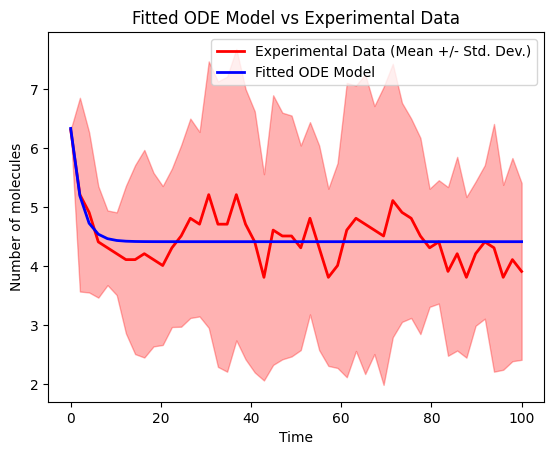

In [38]:
# Plot the mean of the experimental results
plt.plot(trajectory_times, np.mean(experimental_results, axis=0), color='r', linewidth=2, label='Experimental Data (Mean +/- Std. Dev.)')
plt.fill_between(trajectory_times, np.mean(experimental_results, axis=0) - np.std(experimental_results, axis=0), np.mean(experimental_results, axis=0) + np.std(experimental_results, axis=0), color='r', alpha=0.3)

# Plot the fitted ODE model
plt.plot(trajectory_times, ode_model(trajectory_times, *popt), color='b', linewidth=2, label='Fitted ODE Model')

plt.xlabel('Time')
plt.ylabel('Number of molecules')
plt.title('Fitted ODE Model vs Experimental Data')
plt.legend()
plt.show()

### Use an SSA model (Module 3B slides)

As we saw, the ODE solution can match the mean well, but also easily fails unless we carefully setup the problem. Given that this is a toy model, the fitting issue will become even worse for real experiments you may work with in the future.

Let's try the same framework, but instead fit SSA simulations. We can do this two ways.
1. Fit the simulated molecule number mean ($\mu_{SSA}$) and standard deviation ($\sigma_{SSA}$) of many SSA runs to the experimentally observed molecule number mean ($\mu_{experiment}$) and standard deviation ($\sigma_{experiment}$) for all time points using least squares error.
2. Fit the distribution of molecule number from $N$ SSA runs to the experimentally observed molecule number distribution for all time points using a different "error" metric.

For #1, we only need to modify the above ODE fitting code to run the SSA instead of the ODE integrator.

### Define the SSA model

In [ ]:
#FILL IN THESE FUNCTIONS

# Define the reaction rate (propensity) functions
def W(x,t,pars):
  return np.array([pars['k1'],pars['k2']*x[0]])

def ssa_model(t, x0, k1, k2, n_traj):
  # Define the intial condition. It is now a parameter we are fitting for!
  x = np.array([x0])

  # Define the stoichiometry matrix as a 1 (species) by 2 (reaction) numpy array
  S=np.array([[1,-1]])

  # Define the reaction rate parameters as a dictionary
  # These are now parameters we are fitting for!
  pars = {'k1': k1, 'k2': k2}
  # Units are:  k1 = (mg/mL) / minute
  #             k2 = 1 / minute

  # Pass the pars dictionary to the dxdt function
  trajectories = np.zeros((n_traj, len(t)))
  for i in range(n_traj):
      trajectories[i,:] = gillespie1(x, 0, t_max, S, pars, t)

  return trajectories

In [ ]:
# Define a function that calculates the sum of squared errors between the SSA model and the experimental data
def ssa_error_function(params, t, data_mean, data_std, n_traj):
    x0, k1, k2 = params
    model_output = ssa_model(t, x0, k1, k2, n_traj*1000)

    model_mean = np.mean(model_output, axis=0)
    model_std = np.std(model_output, axis=0)

    return np.sum((model_mean - data_mean)**2) + np.sum((model_std - data_std)**2)

# define an initial guess for the parameters [x0,k1,k2]
initial_guess_ssa = [1,0.5,0.5] #FILL IN THESE PARAMETERS

# Define bounds for the parameters [x0, k1, k2]
# These bounds should be reasonable based on the expected values in your system
bounds_ssa = [(0, 10), (0, 10), (0, 10)]

# Fit the ODE model to the mean of the data at the observed time points using minimize
result_ssa = minimize(ssa_error_function, initial_guess_ssa, args=(trajectory_times, np.mean(experimental_results, axis=0), np.std(experimental_results,axis=0), n_traj), bounds=bounds_ssa)

# Extract the fitted parameters
popt_ssa = result_ssa.x

In [ ]:
print(f"Fitted parameters are x(0) = {round(popt_ssa[0],2)}; k1 = {round(popt_ssa[1],2)}; k2 = {round(popt_ssa[2],2)}")
print(f"Correct parameters are x(0) = {round(experimental_parameters[0][0],2)}; k1 = {round(experimental_parameters[1],2)}; k2 = {round(experimental_parameters[2],2)}")